# UDP Checksum Failure Analysis

***By Ali Lotfollahi***

## Abstract

In this notebook, our goal is to compute the probability of UDP checksum failing to detect an existing error. Our inputs in this project are the probability by which a bit alters and also the size of the UDP segment.

## Formulation

Parameters are defined as follows:
- the probability with which a bit is altered is shown by $p$.
- *the length* of a segment is denoted as $m'$.
- *lines of UDP segment sent from the sender*: $Lines$, a binary ($m' \times 32$) matrix.
- *lines of UDP segment received at the receiver*: $Lines'$, a binary ($m' \times 32$) matrix.

Based on $Lines$ and $Lines'$, we can define $Fields$ and $Fields'$ the following way:
$$
    Fields[i, 1:16] := \begin{cases}
        Lines[k,1:16] &; i = 2k + 1 \\
        Lines[k,17:32] &; i = 2k
    \end{cases}
$$

$$
    Fields'[i, 1:16] := \begin{cases}
        Lines'[k,1:16] &; i = 2k + 1 \\
        Lines'[k,17:32] &; i = 2k
    \end{cases}
$$

We know:
- $Fields[1]$ and $Fields[2]$ represent *source port number* and *destination port number* respectively.
- $Fields[3]$ demonstrates $m'$.
- $Fields[4]$ is the *checksum error* that causes the following equation:
$$
    \sum_{i=1}^{2m'} Field[i] = 0
$$
where the zero in 1's complement is represented as both $1_{16}$ and $0_{16}$.

From now on, to avoid unnecessary complications, we define $m$ to be equal to $2m'$

### The Goal

The goal of this notebook is to calculate the following probability:
$$
    Pr(\text{Undetected error}) = Pr(\sum_{i=1}^{m} Fields'[i] = 0) - Pr(\text{No alteration})
$$

Now, if we define:
$$ \Delta[i] := Fields'[i] - Fields[i] $$
the following will be true:
$$ \sum_{i=1}^{m} Fields'[i] = 0 \longleftrightarrow \sum_{i=1}^{m} \Delta[i] = 0

## Parameters

(`M` is put here just for the sake of simplicity)

In [61]:
P = 0.01
SEGMENT_SIZE = 1500

# helping parameter
K = 2 ** 16

In [62]:
M = SEGMENT_SIZE / 2

## Libraries

In [63]:
import numpy as np
import matplotlib.pyplot as plt

## Dynamic Programming

The approach taken to find the probability of $\sum_{i=1}^{2n} \Delta[i] = 0$ is a dynamic algorithm.

### `f[n, k]`

At first, we define 
$$
    g(m, k) = Pr\Big(\sum_{i = 1}^{m} \Delta[i] \Big)
$$

Next, we define `f[n, k]` the following way:
$$
    f(n, k) := g(2^n, k)
$$


It is provable that:
$$
    \forall j \in [1, m): g(m, k) = \sum_{x = 0}^{2^{16} - 2} g(j, x) g(m - j)
$$
which could be interpreted:
$$
    \forall j \in [1, m): g(m, k) = convolv\bigg(g(j, :), g(m - j, :)\bigg)
$$

In [64]:
N = int(np.log2(M))
f = np.zeros((N + 1, K - 1), dtype=np.float128)

If the number of 1s in the 16-bit binary representation of $k$ is denoted by $\lambda(k)$, the chance of $\Delta = k$ when $k \neq 0$ is computed as follows: 
$$f(0, k) = p^{\lambda(k)}\times (1-p)^{16 - \lambda(k)}$$
For $k = 0$, we have: 
$$ f(0, 0) = p^{0}(1-p)^{16} + p^{16}(1-p)^{0} = (1-p)^{16} + p^{16}$$

In [65]:
binary = np.fromfunction(lambda x: x, (K, ), dtype=np.uint16)
binary_repr = np.vectorize(np.binary_repr, otypes=[str])
binary = np.char.count(binary_repr(binary), '1')
prob = np.array((P ** binary) * ((1-P)**(16 - binary)), dtype=np.float128)
f[0] = prob[:-1]
f[0, 0] += prob[-1]
f[0]

array([8.51457771e-01, 8.60058355e-03, 8.60058355e-03, ...,
       9.80100000e-29, 9.90000000e-31, 9.90000000e-31], dtype=float128)

### Building `f`

In [66]:
for i in range(N):
    convolved = np.convolve(f[i], f[i])
    f[i + 1] += convolved[:K - 1]
    f[i + 1, :-1] += convolved[K - 1:]
f

array([[8.51457771e-01, 8.60058355e-03, 8.60058355e-03, ...,
        9.80100000e-29, 9.90000000e-31, 9.90000000e-31],
       [7.24980336e-01, 1.47215626e-02, 1.47215626e-02, ...,
        1.37434800e-24, 2.77617735e-26, 2.77617735e-26],
       [5.25596488e-01, 2.15715376e-02, 2.15715376e-02, ...,
        1.70563753e-20, 6.90555391e-22, 6.90555391e-22],
       ...,
       [9.50181801e-06, 1.05644005e-05, 1.05644005e-05, ...,
        1.12309200e-05, 1.06655354e-05, 1.06655354e-05],
       [1.53372358e-05, 1.53218163e-05, 1.53218163e-05, ...,
        1.53092869e-05, 1.53194537e-05, 1.53194537e-05],
       [1.52590343e-05, 1.52590321e-05, 1.52590321e-05, ...,
        1.52590297e-05, 1.52590313e-05, 1.52590313e-05]], dtype=float128)

### Building $ g(m, :) $

In [67]:
g = np.zeros(K - 1, dtype=np.float128)
g[0] = 1
bin_rep = np.binary_repr(M)
for i, b in enumerate(bin_rep):
    j = N - i
    if b == '1':
        convolved = np.convolve(g, f[j])
        g = convolved[:K-1] 
        g[:-1] += convolved[K-1:]

TypeError: 'float' object cannot be interpreted as an integer

### Plot of `f[n, 0]` Over `n` $\in [0, N]$

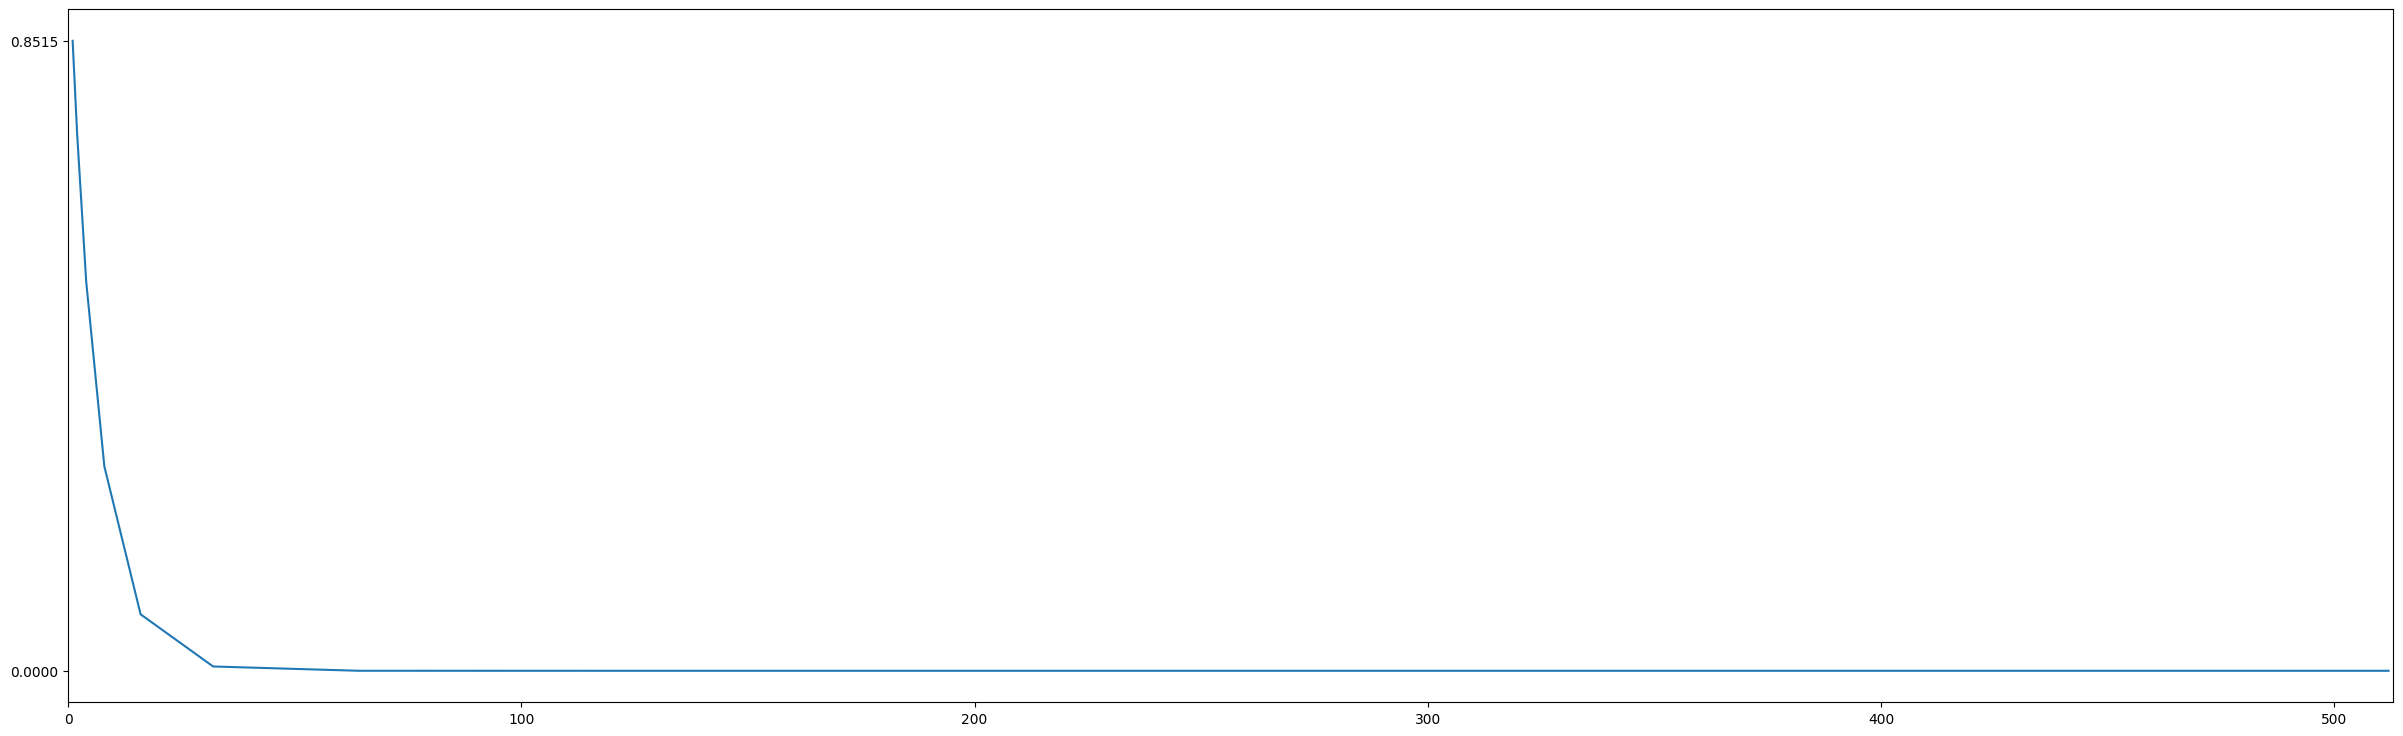

In [ ]:
fig, ax = plt.subplots()
X = 2 ** np.arange(N + 1)
Y = f[:, 0]
ax.plot(X, Y)

ax.set_yticks([np.max(f[:, 0]), np.min(f[:, 0])])
# ax.set_ylim(0, 1)
ax.set_xlim(0, np.max(X) + 1)
fig.set_size_inches(30, 9)
plt.show()

### Calculating the Probability of an Undetected Error

$$
    Pr(\text{Undetected error}) = Pr(\sum_{i=1}^{n} \Delta[i] = 0) - Pr(\text{No alteration})
$$

#### Important Notice

Do notice that we assumed both $\sum fields'[i] = 0$ and $\sum fields'[i] = 2^{16} - 1$ show that no error existed. In UDP checksum, however, only the latter shows no detection. This assumption was made in order to avoid letting in all the $fields$ and $fields'$ values. To implore more, in that case, the probability of checksum not detecting an existing error will be:
$$
    Pr(\text{Undetected error}) = Pr(\sum_{i=1}^{n} \Delta[i] = 0) - Pr(\text{No alteration}) - Pr(\sum_{i=1}^{n} fields'[i] = 0)
$$
in which to compute $Pr(\sum_{i=1}^{n} fields'[i] = 0)$ the values of $fields'$ are needed.

In [ ]:
p = g[0] - (1 - P) ** (16 * M)
print(f'The probability is {p:.10f}')

The probability is 0.0000152590


## Also...

When $m\rightarrow\infty$:
$$ Pr(\text{Undetected error}) = \frac{1}{2^{16} - 1} $$
The intuitive reason behind it would be that when $n\rightarrow \infty$, the infinite times the convolution happens causes the probabilities in $\lim_{m\rightarrow \infty} g(m, k)$ to get homogenized. Thus, it would lose its dependency to $m$ and $p$.

In [ ]:
1 / (2 ** 16 - 1), p - (1 / ((2 ** 16) - 1))

(1.5259021896696422e-05, 3.71876503674402748e-15)

## Conclusion

This article finishes here by computing the probability of not detecting an existing error using UDP checksum. This shows how unlikely it is for UDP checksum to fail finding an error. Therefore, we have proved by the theory of statistics, how valuable it is to put a simple checksum field in a UDP segment.